# BBO-Rietveld Y2O3

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.

## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)


In [ ]:
# import packages
%matplotlib inline

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
sys.path.append('/root/g2full/GSASII/')

In [3]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'Y2O3'
DATA_DIR = 'data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = 'work/' + STUDY_NAME

In [4]:
# make directories
! rm -f $WORK_DIR/$STUDY_NAME*
! mkdir -p $WORK_DIR

In [5]:
@dataclass
class ProjectConfig:
    work_dir: str
    random_seed: int
    data_dir: str
    cif_file: str
    csv_file: str
    prm_file: str

In [6]:
class Project:
    def __init__(self, config: ProjectConfig, trial_number: int):
        import GSASIIscriptable as G2sc
        self.gpx = G2sc.G2Project(newgpx=os.path.join(
            config.work_dir, f'project_seed{config.random_seed}_trial_{trial_number}.gpx'))

        self.hist1 = self.gpx.add_powder_histogram(
            os.path.join(config.data_dir, config.csv_file), os.path.join(config.data_dir, config.prm_file))
        
        self.phase0 = self.gpx.add_phase(os.path.join(config.data_dir, config.cif_file),
                                         phasename=config.cif_file.split(".cif")[0],
                                         histograms=[self.hist1])
        
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In [7]:
# Example usage:
config = ProjectConfig(
    work_dir=WORK_DIR,
    random_seed=RANDOM_SEED,
    data_dir=DATA_DIR,
    cif_file='Y2O3.cif',
    csv_file='Y2O3.csv',
    prm_file='INST_XRY.PRM'
)

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [15, 130]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 150] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [9]:
def objective(trial, config):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_float('Limits lower bound', 15, 130)
    limits_ub = trial.suggest_float('Limits upper bound', limits_lb + 20, 150)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficients', 1, 15)  # [1, 15]
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [15, 150]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    
    def evaluate(config, trial_number, refine_params_list):
        ERROR_PENALTY = 1e9      
        try:
            print(config)
            print(trial_number)
            print(refine_params_list)
            # todo: ここを実装（trial_number）を渡す
            project = Project(config, trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_Y2O3 = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_Y2O3.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            return Rwp
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            return ERROR_PENALTY
            
    Rwp = evaluate(config, trial.number, refine_params_list)
    
    return Rwp

In [11]:
# Create Optuna study

study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            storage=f"sqlite:///{config.work_dir}/history_sqlite.db", 
                            load_if_exists=True,
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

[I 2024-04-03 12:39:27,443] Using an existing study with name 'Y2O3_seed1024' instead of creating a new one.


Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [ ]:
# Optimize
study.optimize(func=lambda trial: objective(trial, config), n_trials=100)

In [ ]:
# Results
df = study.trials_dataframe()
df.columns = [''.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.sort_values('Rwp')

In [30]:
# Best configuration
study.best_params

{'Limits lower bound': 91.81741956486644,
 'Limits upper bound': 124.16688310979242,
 'limits refine': False,
 'Background type': 'log interpolate',
 'Number of coefficients': 14,
 'Background refine': True,
 'Instrument_parameters refine Zero': True,
 'Sample_parameters refine DisplaceX': True,
 'Sample_parameters refine DisplaceY': True,
 'Sample_parameters refine Scale': False,
 'Peakshape_parameters refine U': False,
 'Peakshape_parameters refine V': False,
 'Peakshape_parameters refine W': True,
 'Peakshape_parameters refine X': True,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': False}

In [31]:
# Best Rwp
study.best_value

7.946615605079828

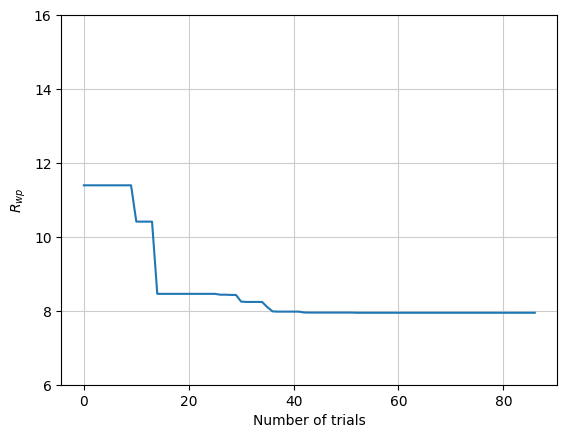

In [32]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([6, 16])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

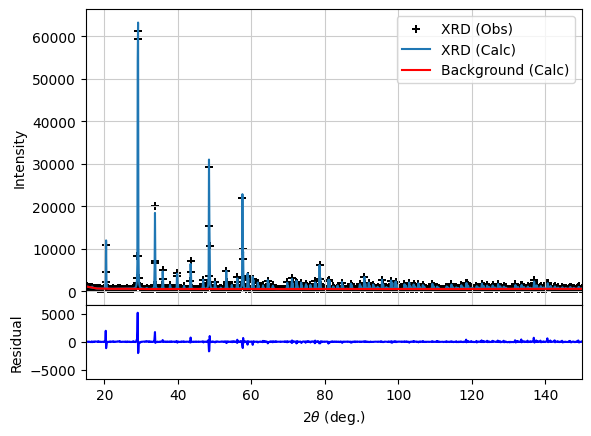

In [37]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        f'{WORK_DIR}/project_seed{RANDOM_SEED}_trial_{study.best_trial.number}.gpx')

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(15, 150)
    ax2.set_xlim(15, 150)
    plt.show()
    
rietveld_plot()